# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../raw_data/transaction_data.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
np.random.seed(42)

recommender = MainRecommender(data_train_lvl_1)

100%|████████████████████████████████████████| 15.0/15 [00:02<00:00,  6.64it/s]
100%|████████████████████████████████████| 5001/5001 [00:00<00:00, 9453.14it/s]


In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 871756, 1106523, 844179]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[9802981, 918046, 1079023, 847962, 907099]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1042907, 1044078, 1133312, 1115576]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[839818, 897083, 7166756, 972445, 879734]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


#### your_code

Сколько пользователей из валидационной выборки для модели первого уровня отсутствует в обучающей?

In [10]:
np.sum(~result_lvl_1['user_id'].isin(data_train_lvl_1['user_id']))

19

Код выдачи рекомендаций был дополнен выдачей топ-N популярных товаров для случая, если пользователь неизвестен.

In [11]:
# Берем максимум рекомендаций - N=500
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=500))
result_lvl_1['similar_items_recommendations'] = result_lvl_1['user_id'].apply( \
                               lambda x: recommender.get_similar_items_recommendation(x, N=500))

Считаем *recall@k* для всех типов рекомендаций, выбирая *k*, и строим графики:

In [12]:
ks = [20, 50, 100, 200, 500]
rec_types = result_lvl_1.columns.drop(['user_id','actual'])

recall_df = pd.DataFrame(index=ks, columns=rec_types)
for rec_type in rec_types:
    for k in ks:
        recall_value = result_lvl_1.apply(lambda row: recall_at_k(row[rec_type], row['actual'], k=k), axis=1).mean()
        recall_df.loc[k, rec_type] = recall_value        

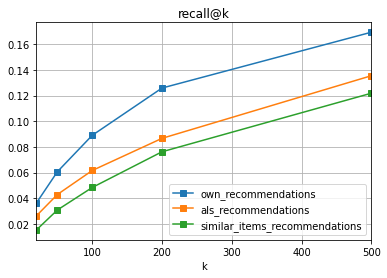

In [13]:
recall_df.plot(marker='s')
plt.title('recall@k')
plt.xlabel('k')
plt.grid(True)
plt.show()

**Выводы (ответы на вопросы):**
 - Наибольшие значения *recall@k* действительно дают *own_recommendations* (с добавление top-popular в случае, если пользоователь новый/неизвестный). Кроме того, они считаются гораздо быстрее остальных.
 - С увеличением *k* происходит и рост метрики *recall@k* для всех типов рекомендаций.
 - Выбор *k* как числа рекомендаций, скорей всего, должен определяться техническими и/или бизнес- ограничениями. К тому же, чем больше *k*, тем медленнее вычисления и выдача рекомендаций. В данном случае динамика роста метрики в зависимости от *k* для всех типов рекомендаций практически одинаковая. Поэтому 50 или 100 - выглядит оптимальным выбором.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [14]:
# your_code

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 